In [1]:
import retro
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import time

env = None

(36, 31)


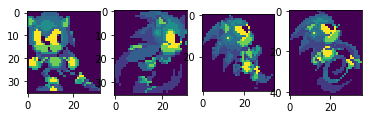

In [7]:
sonics = []
sonic_dir = 'data/sonic2/sonic'
for file in os.listdir( sonic_dir ):
    sonic_dir_file = os.path.join( sonic_dir, file )
    
    sonic = plt.imread( sonic_dir_file )
    sonic *= 255
    sonic = sonic.astype( np.uint8 )

    sonic = cv.cvtColor( sonic, cv.COLOR_RGB2GRAY )
    
    sonics.append( sonic )
    
plt.subplot(1, 4, 1)
plt.imshow( sonics[ 0 ] )
plt.subplot(1, 4, 2)
plt.imshow( sonics[ 1 ] )
plt.subplot(1, 4, 3)
plt.imshow( sonics[ 2 ] )
plt.subplot(1, 4, 4)
plt.imshow( sonics[ 3 ] )

In [6]:
if env is None:
    env = retro.make(game='SonicTheHedgehog2-Genesis', state='EmeraldHillZone.Act1')
_ = env.reset()

env.render()

frame, reward, done, info = env.step( env.action_space.sample() )

1.8364202976226807


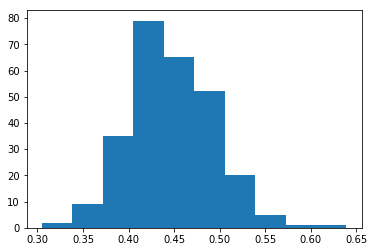

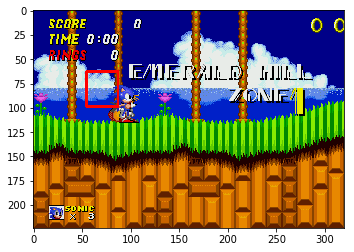

In [8]:
def findInFrame( template, frame_alpha ):
    w, h = template.shape[ 0:2 ]
    results = cv.matchTemplate( frame_alpha, template, cv.TM_CCOEFF_NORMED )

    _, score, _, max_loc = cv.minMaxLoc( results )
    return score, ( max_loc[ 0 ], max_loc[ 1 ] ), ( max_loc[ 0 ] + h, max_loc[ 1 ] + w  )

scores = []
all_sprite_results = []

frame_alpha = np.dstack( ( frame, np.full( frame.shape[ 0:2 ], 255 ) ) )
frame_alpha = frame_alpha.astype( np.uint8 )
frame_alpha = cv.cvtColor( frame_alpha, cv.COLOR_RGB2GRAY )

start_time = time.time()
for sonic in sonics:
    score, tl, br = findInFrame( sonic, frame_alpha )
    all_sprite_results.append( ( score, tl, br ) )
    scores.append( score )
print( time.time() - start_time )
    
highest_score = np.max( scores )
highest_score_idx = np.argmax( scores )

plt.hist( scores )
plt.subplots()

score, tl, br = all_sprite_results[ highest_score_idx ]

cv.rectangle( frame, tl, br, 255, 2 )
plt.imshow( frame )

0.6391028165817261 161


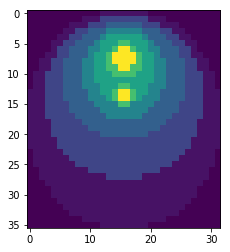

In [10]:
plt.imshow( sonics[ highest_score_idx ] )
print( highest_score, highest_score_idx )
